# Sentiment analysis

This tutorial demonstrates text classification starting from plain text files stored on disk. You'll train a binary classifier to perform sentiment analysis on an IMDB dataset. At the end of the notebook, there is an exercise for you to try, in which you'll train a multi-class classifier to predict the tag for a programming question on Stack Overflow.

This notebook trains a sentiment analysis model to classify movie reviews as *positive* or *negative*, based on the text of the review. This is an example of *binary*—or two-class—classification, an important and widely applicable kind of machine learning problem.

You'll use the [Large Movie Review Dataset](https://ai.stanford.edu/~amaas/data/sentiment/) that contains the text of 50,000 movie reviews from the [Internet Movie Database](https://www.imdb.com/). These are split into 25,000 reviews for training and 25,000 reviews for testing. The training and testing sets are *balanced*, meaning they contain an equal number of positive and negative reviews.





#Importing libraries

In [ ]:
import os
import re
import numpy
import shutil                  #for file deletion, etc
import string
import tensorflow as tf
import matplotlib.pyplot as plt

from tensorflow.keras import layers
from tensorflow.keras import losses

print(tf.__version__)

2.7.0


# Download and explore the IMDB dataset

Let's download and extract the dataset, then explore the directory structure.

In [ ]:
url = "https://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz"

dataset_path = tf.keras.utils.get_file("aclImdb_v1", url,
                                  untar=True, cache_dir='.',
                                  cache_subdir = '')

print(type(dataset_path))
print(dataset_path)

84140032/84125825 [==============================] - 3s 0us/step
<class 'str'>
./aclImdb_v1


In [ ]:
dataset_dir = os.path.join(os.path.dirname(dataset_path), 'aclImdb')
dataset_dir

'./aclImdb'

In [ ]:
os.listdir(dataset_dir)

['README', 'train', 'imdbEr.txt', 'test', 'imdb.vocab']

In [ ]:
#! more ./aclImdb/imdb.vocab

In [ ]:
train_dir = os.path.join(dataset_dir, 'train')
os.listdir(train_dir)

['pos',
 'unsup',
 'neg',
 'urls_pos.txt',
 'unsupBow.feat',
 'urls_neg.txt',
 'urls_unsup.txt',
 'labeledBow.feat']

The `aclImdb/train/pos` and `aclImdb/train/neg` directories contain many text files, each of which is a single movie review. Let's take a look at one of them.

In [ ]:
print(len(os.listdir(os.path.join(train_dir,'pos'))))
print(len(os.listdir(os.path.join(train_dir,'neg'))))
print(len(os.listdir(os.path.join(train_dir,'unsup'))))

12500
12500
50000


In [ ]:
sample_file = os.path.join(train_dir, 'pos/1181_9.txt')
with open(sample_file) as f:
  print(f.read())

Rachel Griffiths writes and directs this award winning short film. A heartwarming story about coping with grief and cherishing the memory of those we've loved and lost. Although, only 15 minutes long, Griffiths manages to capture so much emotion and truth onto film in the short space of time. Bud Tingwell gives a touching performance as Will, a widower struggling to cope with his wife's death. Will is confronted by the harsh reality of loneliness and helplessness as he proceeds to take care of Ruth's pet cow, Tulip. The film displays the grief and responsibility one feels for those they have loved and lost. Good cinematography, great direction, and superbly acted. It will bring tears to all those who have lost a loved one, and survived.


In [ ]:
sample_file = os.path.join(train_dir,'unsup/24636_0.txt')
with open(sample_file) as f:
  print(f.read())

This Would make a excellent remake, just a remarkable story. The acting is wonderful as well as the direction. I first saw this episode in 1995, and it has haunted me ever since. It has created a fascination with ww1 and I now collect ww1 artifacts. This story could easily be adapted in to a feature film or even a mini serious. It states at the end of the story that it is based on actual events. Its hard to believe that it has never been mentioned since. I am currently working on trying to track down actual historical data about the event. This is a powerful story, please keep in mind the time and,low budget this was filmed in. Wish me luck on my research. Scott


# Load dataset in tf.data

Next, you will load the data off disk and prepare it into a format suitable for training. To do so, you will use the helpful [text_dataset_from_directory](https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/text_dataset_from_directory) utility, which expects a directory structure as follows.



```
main_directory/
...class_a/
......a_text_1.txt
......a_text_2.txt
...class_b/
......b_text_1.txt
......b_text_2.txt
```

To prepare a dataset for binary classification, you will need two folders on disk, corresponding to `class_a` and `class_b`. These will be the positive and negative movie reviews, which can be found in  `aclImdb/train/pos` and `aclImdb/train/neg`. As the IMDB dataset contains additional folders, you will remove them before using this utility.

In [ ]:
remove_dir = os.path.join(train_dir, 'unsup')
shutil.rmtree(remove_dir)

Next, you will use the `text_dataset_from_directory` utility to create a labeled `tf.data.Dataset`. [tf.data](https://www.tensorflow.org/guide/data) is a powerful collection of tools for working with data. 

When running a machine learning experiment, it is a best practice to divide your dataset into three splits: [train](https://developers.google.com/machine-learning/glossary#training_set), [validation](https://developers.google.com/machine-learning/glossary#validation_set), and [test](https://developers.google.com/machine-learning/glossary#test-set). 

The IMDB dataset has already been divided into train and test, but it lacks a validation set. Let's create a validation set using an 80:20 split of the training data by using the `validation_split` argument below.

Note:  When using the `validation_split` and `subset` arguments, make sure to either specify a random seed, or to pass `shuffle=False`, so that the validation and training splits have no overlap.

In [ ]:
batch_size = 32
seed = 42

raw_train_ds = tf.keras.utils.text_dataset_from_directory('aclImdb/train', 
                                                          batch_size=batch_size, 
                                                          validation_split=0.2, 
                                                          subset='training', 
                                                          seed=seed)

Found 25000 files belonging to 2 classes.
Using 20000 files for training.


In [ ]:
raw_val_ds = tf.keras.utils.text_dataset_from_directory('aclImdb/train', 
                                                        batch_size=batch_size, 
                                                        validation_split=0.2, 
                                                        subset='validation', 
                                                        seed=seed)

Found 25000 files belonging to 2 classes.
Using 5000 files for validation.


In [ ]:
raw_test_ds = tf.keras.utils.text_dataset_from_directory('aclImdb/test', 
                                                          batch_size=batch_size)

Found 25000 files belonging to 2 classes.


As you can see above, there are 25,000 examples in the training folder, of which you will use 80% (or 20,000) for training. As you will see in a moment, you can train a model by passing a dataset directly to `model.fit`. If you're new to `tf.data`, you can also iterate over the dataset and print out a few examples as follows.

In [ ]:
print(type(raw_train_ds))

<class 'tensorflow.python.data.ops.dataset_ops.BatchDataset'>


In [ ]:
raw_train_ds.take(1)

<TakeDataset shapes: ((None,), (None,)), types: (tf.string, tf.int32)>

In [ ]:
for text_batch, label_batch in raw_train_ds.take(1):
  print(len(text_batch.numpy()))
  for i in range(3):
    print("Review:", text_batch.numpy()[i])
    print("Label:", label_batch.numpy()[i])

32
Review: b'Silent Night, Deadly Night 5 is the very last of the series, and like part 4, it\'s unrelated to the first three except by title and the fact that it\'s a Christmas-themed horror flick.<br /><br />Except to the oblivious, there\'s some obvious things going on here...Mickey Rooney plays a toymaker named Joe Petto and his creepy son\'s name is Pino. Ring a bell, anyone? Now, a little boy named Derek heard a knock at the door one evening, and opened it to find a present on the doorstep for him. Even though it said "don\'t open till Christmas", he begins to open it anyway but is stopped by his dad, who scolds him and sends him to bed, and opens the gift himself. Inside is a little red ball that sprouts Santa arms and a head, and proceeds to kill dad. Oops, maybe he should have left well-enough alone. Of course Derek is then traumatized by the incident since he watched it from the stairs, but he doesn\'t grow up to be some killer Santa, he just stops talking.<br /><br />There\'

Notice the reviews contain raw text (with punctuation and occasional HTML tags like `<br/>`). You will show how to handle these in the following section. 

The labels are 0 or 1. To see which of these correspond to positive and negative movie reviews, you can check the `class_names` property on the dataset.


In [ ]:
print("Label 0 corresponds to", raw_train_ds.class_names[0])
print("Label 1 corresponds to", raw_train_ds.class_names[1])

Label 0 corresponds to neg
Label 1 corresponds to pos


# Prepare the dataset for training

Next, you will standardize, tokenize, and vectorize the data using the helpful `tf.keras.layers.TextVectorization` layer. 

**Standardization** refers to preprocessing the text, typically to remove punctuation or HTML elements to simplify the dataset. 

**Tokenization** refers to splitting strings into tokens (for example, splitting a sentence into individual words, by splitting on whitespace). 

**Vectorization** refers to converting tokens into numbers so they can be fed into a neural network. All of these tasks can be accomplished with this layer.

As you saw above, the reviews contain various HTML tags like `<br />`. These tags will **not** be removed by the default standardizer in the `TextVectorization` layer (which converts text to lowercase and strips punctuation by default, but doesn't strip HTML). You will write a custom standardization function to remove the HTML.

Note: To prevent [training-testing skew](https://developers.google.com/machine-learning/guides/rules-of-ml#training-serving_skew) (also known as training-serving skew), it is important to preprocess the data identically at train and test time. To facilitate this, the `TextVectorization` layer can be included directly inside your model, as shown later in this tutorial.

In [ ]:
def custom_standardization(input_data):
  lowercase = tf.strings.lower(input_data)
  stripped_html = tf.strings.regex_replace(lowercase, '<br />', ' ')
  return tf.strings.regex_replace(stripped_html,
                                  '[%s]' % re.escape(string.punctuation),
                                  '')

Next, you will create a `TextVectorization` layer. You will use this layer to standardize, tokenize, and vectorize our data. You set the `output_mode` to `int` to create unique integer indices for each token.

Note that you're using the default split function, and the custom standardization function you defined above. You'll also define some constants for the model, like an explicit maximum `sequence_length`, which will cause the layer to pad or truncate sequences to exactly `sequence_length` values.

In [ ]:
max_features = 10000
sequence_length = 250

vectorize_layer = layers.TextVectorization(standardize=custom_standardization,
                                            max_tokens=max_features,
                                            output_mode='int',
                                            output_sequence_length=sequence_length)

Next, you will call `adapt` to fit the state of the preprocessing layer to the dataset. This will cause the model to build an index of strings to integers.

Note: It's important to only use your training data when calling adapt (using the test set would leak information).

In [ ]:
# Make a text-only dataset (without labels), then call adapt
train_text = raw_train_ds.map(lambda x, y: x)
vectorize_layer.adapt(train_text)

Let's create a function to see the result of using this layer to preprocess some data.

In [ ]:
def vectorize_text(text, label):
  text = tf.expand_dims(text, -1)
  return vectorize_layer(text), label

In [ ]:
# retrieve a batch (of 32 reviews and labels) from the dataset
text_batch, label_batch = next(iter(raw_train_ds))
first_review, first_label = text_batch[0], label_batch[0]
print("Review", first_review)
print("Label", raw_train_ds.class_names[first_label])
print("Vectorized review", vectorize_text(first_review, first_label))

Review tf.Tensor(b'Recipe for one of the worst movies of all time: a she-male villain who looks like it escaped from the WWF, has terrible aim with a gun that has inconsistent effects (the first guy she shoots catches on fire but when she shoots anyone else they just disappear) and takes time out to pet a deer. Then you got the unlikable characters, 30 year old college students, a lame attempt at a surprise ending and lots, lots more. Avoid at all costs.', shape=(), dtype=string)
Label neg
Vectorized review (<tf.Tensor: shape=(1, 250), dtype=int64, numpy=
array([[9257,   15,   28,    5,    2,  241,   91,    5,   30,   58,    4,
           1, 1011,   36,  262,   38,    9, 3891,   35,    2,    1,   43,
         382, 5223,   16,    4, 1113,   12,   43, 5739,  300,    2,   83,
         225,   55, 3209, 3898,   20,  973,   18,   51,   55, 3209,  250,
         320,   34,   40, 4386,    3,  294,   58,   44,    6, 2911,    4,
        6757,   92,   22,  184,    2, 4916,  100, 1221,  336,  161, 

As you can see above, each token has been replaced by an integer. You can lookup the token (string) that each integer corresponds to by calling `.get_vocabulary()` on the layer.

In [ ]:
dir(vectorize_layer)

In [ ]:
print("1287 ---> ",vectorize_layer.get_vocabulary()[1287])
print(" 313 ---> ",vectorize_layer.get_vocabulary()[313])
print('Vocabulary size: {}'.format(len(vectorize_layer.get_vocabulary())))

1287 --->  silent
 313 --->  night
Vocabulary size: 10000


You are nearly ready to train your model. As a final preprocessing step, you will apply the TextVectorization layer you created earlier to the train, validation, and test dataset.

In [ ]:
train_ds = raw_train_ds.map(vectorize_text)
val_ds = raw_val_ds.map(vectorize_text)
test_ds = raw_test_ds.map(vectorize_text)

# Configure the dataset for performance



These are two important methods you should use when loading data to make sure that I/O does not become blocking.

`.cache()` keeps data in memory after it's loaded off disk. This will ensure the dataset does not become a bottleneck while training your model. If your dataset is too large to fit into memory, you can also use this method to create a performant on-disk cache, which is more efficient to read than many small files.

`.prefetch()` overlaps data preprocessing and model execution while training. 

You can learn more about both methods, as well as how to cache data to disk in the [data performance guide](https://www.tensorflow.org/guide/data_performance).

In [ ]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)
test_ds = test_ds.cache().prefetch(buffer_size=AUTOTUNE)

# Create the model

It's time to create your neural network:

In [ ]:
embedding_dim = 16

In [ ]:
model = tf.keras.Sequential([
                            layers.Embedding(max_features + 1, embedding_dim),
                            layers.Dropout(0.2),
                            layers.GlobalAveragePooling1D(),
                            layers.Dropout(0.2),
                            layers.Dense(1)
                            ])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, None, 16)          160016    
                                                                 
 dropout (Dropout)           (None, None, 16)          0         
                                                                 
 global_average_pooling1d (G  (None, 16)               0         
 lobalAveragePooling1D)                                          
                                                                 
 dropout_1 (Dropout)         (None, 16)                0         
                                                                 
 dense (Dense)               (None, 1)                 17        
                                                                 
Total params: 160,033
Trainable params: 160,033
Non-trainable params: 0
__________________________________________________

The layers are stacked sequentially to build the classifier:

1. The first layer is an `Embedding` layer. This layer takes the integer-encoded reviews and looks up an embedding vector for each word-index. These vectors are learned as the model trains. The vectors add a dimension to the output array. The resulting dimensions are: `(batch, sequence, embedding)`.  To learn more about embeddings, see the [word embedding tutorial](../text/word_embeddings.ipynb).
2. Next, a `GlobalAveragePooling1D` layer returns a fixed-length output vector for each example by averaging over the sequence dimension. This allows the model to handle input of variable length, in the simplest way possible.
3. This fixed-length output vector is piped through a fully-connected (`Dense`) layer with 16 hidden units. 
4. The last layer is densely connected with a single output node.

### Loss function and optimizer

A model needs a loss function and an optimizer for training. Since this is a binary classification problem and the model outputs a probability (a single-unit layer with a sigmoid activation), you'll use `losses.BinaryCrossentropy` loss function.

Now, configure the model to use an optimizer and a loss function:

In [ ]:
model.compile(loss=losses.BinaryCrossentropy(from_logits=True),
              optimizer='adam',
              metrics=tf.metrics.BinaryAccuracy(threshold=0.0))

### Train the model

You will train the model by passing the `dataset` object to the fit method.

In [ ]:
epochs = 10
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=epochs)

Epoch 1/10
625/625 [==============================] - 13s 19ms/step - loss: 0.6646 - binary_accuracy: 0.6938 - val_loss: 0.6158 - val_binary_accuracy: 0.7722
Epoch 2/10
625/625 [==============================] - 5s 7ms/step - loss: 0.5491 - binary_accuracy: 0.8005 - val_loss: 0.4991 - val_binary_accuracy: 0.8228
Epoch 3/10
625/625 [==============================] - 4s 7ms/step - loss: 0.4454 - binary_accuracy: 0.8443 - val_loss: 0.4209 - val_binary_accuracy: 0.8468
Epoch 4/10
625/625 [==============================] - 4s 7ms/step - loss: 0.3789 - binary_accuracy: 0.8658 - val_loss: 0.3742 - val_binary_accuracy: 0.8600
Epoch 5/10
625/625 [==============================] - 4s 7ms/step - loss: 0.3360 - binary_accuracy: 0.8797 - val_loss: 0.3453 - val_binary_accuracy: 0.8668
Epoch 6/10
625/625 [==============================] - 5s 7ms/step - loss: 0.3056 - binary_accuracy: 0.8884 - val_loss: 0.3262 - val_binary_accuracy: 0.8724
Epoch 7/10
625/625 [==============================] - 4s 7ms/s

### Evaluate the model

Let's see how the model performs. Two values will be returned. Loss (a number which represents our error, lower values are better), and accuracy.

In [ ]:
loss, accuracy = model.evaluate(test_ds)

print("Loss: ", loss)
print("Accuracy: ", accuracy)

782/782 [==============================] - 9s 11ms/step - loss: 0.3109 - binary_accuracy: 0.8734
Loss:  0.31085628271102905
Accuracy:  0.8733599781990051


This fairly naive approach achieves an accuracy of about 86%.

### Create a plot of accuracy and loss over time

`model.fit()` returns a `History` object that contains a dictionary with everything that happened during training:

In [ ]:
history_dict = history.history
history_dict.keys()

dict_keys(['loss', 'binary_accuracy', 'val_loss', 'val_binary_accuracy'])

There are four entries: one for each monitored metric during training and validation. You can use these to plot the training and validation loss for comparison, as well as the training and validation accuracy:

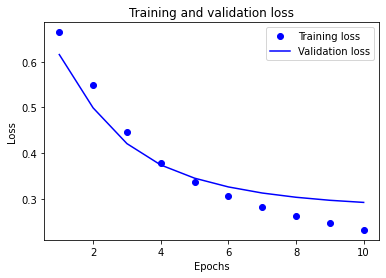

In [ ]:
acc = history_dict['binary_accuracy']
val_acc = history_dict['val_binary_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)

# "bo" is for "blue dot"
plt.plot(epochs, loss, 'bo', label='Training loss')
# b is for "solid blue line"
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

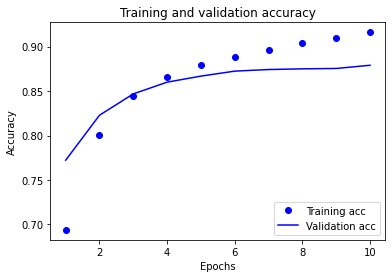

In [ ]:
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')

plt.show()

In this plot, the dots represent the training loss and accuracy, and the solid lines are the validation loss and accuracy.

Notice the training loss *decreases* with each epoch and the training accuracy *increases* with each epoch. This is expected when using a gradient descent optimization—it should minimize the desired quantity on every iteration.

This isn't the case for the validation loss and accuracy—they seem to peak before the training accuracy. This is an example of overfitting: the model performs better on the training data than it does on data it has never seen before. After this point, the model over-optimizes and learns representations *specific* to the training data that do not *generalize* to test data.

For this particular case, you could prevent overfitting by simply stopping the training when the validation accuracy is no longer increasing. One way to do so is to use the `tf.keras.callbacks.EarlyStopping` callback.

# Export the model

In the code above, you applied the `TextVectorization` layer to the dataset before feeding text to the model. If you want to make your model capable of processing raw strings (for example, to simplify deploying it), you can include the `TextVectorization` layer inside your model. To do so, you can create a new model using the weights you just trained.

In [ ]:
export_model = tf.keras.Sequential([
  vectorize_layer,
  model,
  layers.Activation('sigmoid')
])

export_model.compile(
    loss=losses.BinaryCrossentropy(from_logits=False), optimizer="adam", metrics=['accuracy']
)

# Test it with `raw_test_ds`, which yields raw strings
loss, accuracy = export_model.evaluate(raw_test_ds)
print(accuracy)

782/782 [==============================] - 9s 11ms/step - loss: 0.3109 - accuracy: 0.8734
0.8733599781990051


### Inference on new data

To get predictions for new examples, you can simply call `model.predict()`.

In [ ]:
examples = [
  "The movie was great!",
  "The movie was okay.",
  "The movie was terrible..."
]

export_model.predict(examples)

array([[0.6065483],
       [0.4288264],
       [0.3501131]], dtype=float32)

Including the text preprocessing logic inside your model enables you to export a model for production that simplifies deployment, and reduces the potential for [train/test skew](https://developers.google.com/machine-learning/guides/rules-of-ml#training-serving_skew).

There is a performance difference to keep in mind when choosing where to apply your TextVectorization layer. Using it outside of your model enables you to do asynchronous CPU processing and buffering of your data when training on GPU. So, if you're training your model on the GPU, you probably want to go with this option to get the best performance while developing your model, then switch to including the TextVectorization layer inside your model when you're ready to prepare for deployment.

Visit this [tutorial](https://www.tensorflow.org/tutorials/keras/save_and_load) to learn more about saving models.

# The END